In [1]:
import numpy as np
import torch


import json
from torch.utils.data import DataLoader
from torch.optim import SGD, AdamW
from torch import nn

In [2]:
import utils_generic as generic
import rrnn_st as rrnn
import model_confs as confs


import train

from gensim.models import KeyedVectors

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.manual_seed(27)
word2vec_path = r"C:\Users\FarinhOso\gensim-data\word2vec-google-news-300\word2vec-google-news-300.gz"
word2vec_model =  KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

# Datos ConvAI2

In [4]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [5]:
convai_train = data['train']
convai_val = data['validation']


word_to_index = word2vec_model.key_to_index

convai_train_token = generic.tokenize_dataset_rrnn(convai_train,['about','to','as'],word_to_index) 
convai_val_token = generic.tokenize_dataset_rrnn(convai_val,['about','to','as'],word_to_index) 

In [6]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = rrnn.DatasetSingleTaskSimple(convai_train_token,task,eval=False)

In [7]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = rrnn.DatasetSingleTaskSimple(convai_val_token,task,eval=False)

# Datos md_gender

In [8]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [9]:
md_tokenized = generic.tokenize_dataset_rrnn(md_data,['about','to','as'],word_to_index) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = rrnn.DatasetSingleTaskSimple(md_tokenized,task,eval=True)

# Creación dataloaders

In [11]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn)

In [12]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn)

In [10]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=rrnn.collate_fn)

# ABOUT

In [11]:
emb_dim = 20
vocab_size = len(word_to_index)
num_labels = 2
lstm_hidden_dim = 128

In [14]:
model = rrnn.SingleTaskRRNN2(emb_dim,vocab_size,lstm_hidden_dim,emb_weights=word2vec_model.vectors).to(device)
save_path='m1_rrnn_simple_about_w2v'

In [14]:
save_path='m1_rrnn_simple_about_w2v'

In [15]:
for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.4897959183673469 

Using scikit learn accuracy por género en el conjunto about
MALE 1.0
FEMALE 0.0 

GLOBAL: 0.5189393939393939 

Using scikit learn accuracy por género en el conjunto to
MALE 1.0
FEMALE 0.0 

GLOBAL: 0.516297262059974 

Using scikit learn accuracy por género en el conjunto as
MALE 1.0
FEMALE 0.0 



  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6874145240318484 	 Validation loss: 0.6875186067516521 	 
  1%|          | 574/57400 [00:18<04:44, 199.82it/s]
Epoch 2 	 Training loss: 0.6859604933328329 	 Validation loss: 0.6865520830881797 	 
  2%|▏         | 1148/57400 [00:27<04:25, 211.55it/s]
Epoch 3 	 Training loss: 0.6848523422608392 	 Validation loss: 0.6857641460531849 	 
  3%|▎         | 1722/57400 [00:37<04:16, 216.67it/s]
Epoch 4 	 Training loss: 0.6840164444380106 	 Validation loss: 0.6852397837881314 	 
  4%|▍         | 2296/57400 [00:47<04:16, 214.71it/s]
Epoch 5 	 Training loss: 0.6833820653501703 	 Validation loss: 0.6847785377906541 	 
  5%|▌         | 2870/57400 [00:56<04:25, 205.15it/s]
Epoch 6 	 Training loss: 0.6828686631307369 	 Validation loss: 0.6844646809464794 	 
  6%|▌         | 3444/57400 [01:06<04:20, 207.42it/s]
Epoch 7 	 Training loss: 0.6824733263939515 	 Validation loss: 0.6842386399285268 	 
  7%|▋         | 4018/57400 [01:15<04:17, 207.17it/s]
Epoch 8 	 Training loss: 0.6

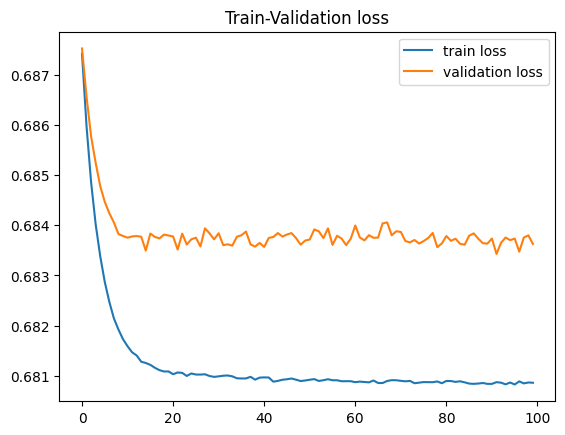

In [16]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path)

In [15]:
model = rrnn.SingleTaskRRNN2(emb_dim,vocab_size,lstm_hidden_dim,emb_weights=word2vec_model.vectors).to(device)
model.load_state_dict(torch.load(save_path))

for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.4897959183673469 

Using scikit learn accuracy por género en el conjunto about
MALE 1.0
FEMALE 0.0 

GLOBAL: 0.5189393939393939 

Using scikit learn accuracy por género en el conjunto to
MALE 1.0
FEMALE 0.0 

GLOBAL: 0.516297262059974 

Using scikit learn accuracy por género en el conjunto as
MALE 1.0
FEMALE 0.0 



# TO

In [15]:
emb_dim = 20
vocab_size = len(word_to_index)
num_labels = 2
lstm_hidden_dim = 128

In [15]:
model = rrnn.SingleTaskRRNN2(emb_dim,vocab_size,lstm_hidden_dim,emb_weights=word2vec_model.vectors).to(device)
save_path='m1_rrnn_simple_to_w2v'

RuntimeError: CUDA out of memory. Tried to allocate 3.35 GiB (GPU 0; 6.00 GiB total capacity; 3.36 GiB already allocated; 1014.00 MiB free; 3.38 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path)

In [ ]:
model = rrnn.SingleTaskRRNN2(emb_dim,vocab_size,lstm_hidden_dim,emb_weights=word2vec_model.vectors).to(device)
model.load_state_dict(torch.load('m1_rrnn_simple_to_w2v'))

for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

# AS

In [16]:
model = rrnn.SingleTaskRRNN2(emb_dim,vocab_size,lstm_hidden_dim,emb_weights=word2vec_model.vectors).to(device)
save_path='m1_rrnn_simple_as_w2v'

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6934500490331483 	 Validation loss: 0.6916101271823302 	 
  1%|          | 574/57400 [00:32<25:21, 37.34it/s]
Epoch 2 	 Training loss: 0.6934501663733027 	 Validation loss: 0.6921690793360694 	 
  2%|▏         | 1148/57400 [00:49<26:20, 35.60it/s]
Epoch 3 	 Training loss: 0.6932951671944263 	 Validation loss: 0.6922091397188478 	 
  3%|▎         | 1722/57400 [01:04<23:37, 39.28it/s]
Epoch 4 	 Training loss: 0.6932447795668546 	 Validation loss: 0.6923917612787021 	 
  4%|▍         | 2296/57400 [01:19<25:47, 35.61it/s]
Epoch 5 	 Training loss: 0.6933166429348524 	 Validation loss: 0.6925751991191152 	 
  5%|▌         | 2870/57400 [01:36<25:53, 35.09it/s]
Epoch 6 	 Training loss: 0.6932669861391446 	 Validation loss: 0.6923211823075505 	 
  6%|▌         | 3444/57400 [01:55<26:36, 33.80it/s]
Epoch 7 	 Training loss: 0.6932317801468879 	 Validation loss: 0.6924857396190449 	 
  7%|▋         | 4018/57400 [02:13<26:06, 34.08it/s]
Epoch 8 	 Training loss: 0.69314465

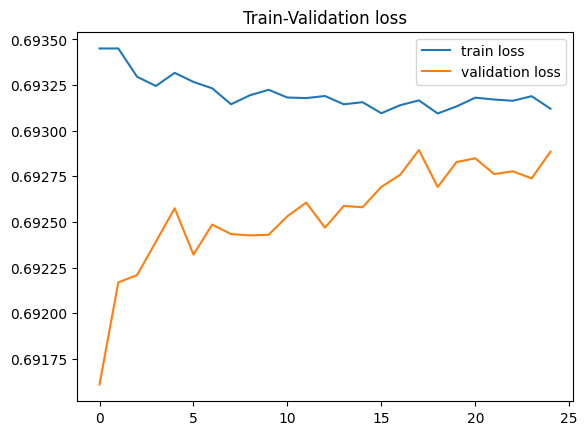

In [18]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path)

In [17]:
model = rrnn.SingleTaskRRNN2(emb_dim,vocab_size,lstm_hidden_dim,emb_weights=word2vec_model.vectors).to(device)
model.load_state_dict(torch.load(save_path))

for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.5102040816326531 

Using scikit learn accuracy por género en el conjunto about
MALE 0.0
FEMALE 1.0 

GLOBAL: 0.4810606060606061 

Using scikit learn accuracy por género en el conjunto to
MALE 0.0
FEMALE 1.0 

GLOBAL: 0.48370273794002605 

Using scikit learn accuracy por género en el conjunto as
MALE 0.0
FEMALE 1.0 



# AdamW

## ABOUT

In [18]:
model = rrnn.SingleTaskRRNN2(emb_dim,vocab_size,lstm_hidden_dim,emb_weights=word2vec_model.vectors).to(device)
save_path='m1_rrnn_simple_about_adam_w2v'

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6256129473759322 	 Validation loss: 0.5326685521562221 	 
  1%|          | 574/57400 [00:08<06:12, 152.40it/s]
Epoch 2 	 Training loss: 0.48018206671555286 	 Validation loss: 0.45109148399304533 	 
  2%|▏         | 1148/57400 [00:17<05:42, 164.20it/s]
Epoch 3 	 Training loss: 0.4489126128082907 	 Validation loss: 0.4348704845218335 	 
  3%|▎         | 1722/57400 [00:26<06:37, 140.15it/s]
Epoch 4 	 Training loss: 0.4383363221165195 	 Validation loss: 0.43798921673984853 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [00:30<06:45, 135.99it/s]
Epoch 5 	 Training loss: 0.430972082066619 	 Validation loss: 0.42299278055207207 	 
  5%|▌         | 2870/57400 [00:39<07:12, 126.03it/s]
Epoch 6 	 Training loss: 0.4255151466729334 	 Validation loss: 0.4290856365430153 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [00:44<06:27, 139.24it/s]
Epoch 7 	 Training loss: 0.42136598895028077 	 Validation loss: 0.42847003371028575 	 

2 epoch without im

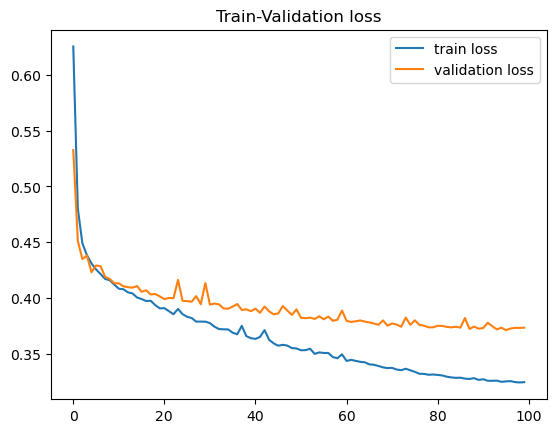

In [20]:
learning_rate = 5e-5
optimizer = AdamW(model.parameters(), lr=learning_rate)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path)

In [21]:
model = rrnn.SingleTaskRRNN2(emb_dim,vocab_size,lstm_hidden_dim,emb_weights=word2vec_model.vectors).to(device)
model.load_state_dict(torch.load(save_path))

for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.7436224489795918 

Using scikit learn accuracy por género en el conjunto about
MALE 0.7916666666666666
FEMALE 0.6975 

GLOBAL: 0.5593434343434344 

Using scikit learn accuracy por género en el conjunto to
MALE 0.6277372262773723
FEMALE 0.48556430446194226 

GLOBAL: 0.6427640156453716 

Using scikit learn accuracy por género en el conjunto as
MALE 0.6818181818181818
FEMALE 0.601078167115903 



## TO

In [16]:
model = rrnn.SingleTaskRRNN2(emb_dim,vocab_size,lstm_hidden_dim,emb_weights=word2vec_model.vectors).to(device)
save_path='m1_rrnn_simple_to_adam_w2v'

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.693121461087403 	 Validation loss: 0.6923688407671653 	 
  1%|          | 574/57400 [00:09<08:16, 114.41it/s]
Epoch 2 	 Training loss: 0.6931243573123985 	 Validation loss: 0.6923588837607432 	 
  2%|▏         | 1148/57400 [00:19<07:07, 131.45it/s]
Epoch 3 	 Training loss: 0.6930652832943388 	 Validation loss: 0.6932740595381138 	 
  3%|▎         | 1722/57400 [00:24<07:08, 129.79it/s]
Epoch 4 	 Training loss: 0.69306499326686 	 Validation loss: 0.692774590799364 	 
  4%|▍         | 2296/57400 [00:29<08:02, 114.28it/s]
Epoch 5 	 Training loss: 0.6930949556079891 	 Validation loss: 0.692996817120051 	 
  5%|▌         | 2870/57400 [00:34<07:29, 121.23it/s]
Epoch 6 	 Training loss: 0.6930468870579989 	 Validation loss: 0.6930346842539512 	 
  6%|▌         | 3444/57400 [00:39<07:54, 113.80it/s]
Epoch 7 	 Training loss: 0.692985921994319 	 Validation loss: 0.6924911343445213 	 
  7%|▋         | 4018/57400 [00:44<06:45, 131.61it/s]
Epoch 8 	 Training loss: 0.6928837

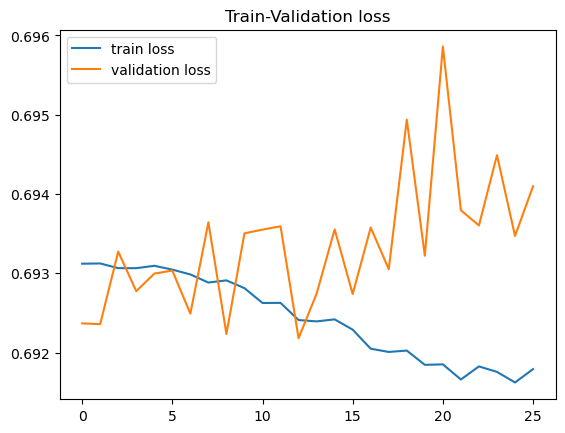

In [23]:
learning_rate = 5e-5
optimizer = AdamW(model.parameters(), lr=learning_rate)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path)

In [ ]:
del model
torch.cuda.empty_cache() 

In [20]:
model = rrnn.SingleTaskRRNN2(emb_dim,vocab_size,lstm_hidden_dim,emb_weights=word2vec_model.vectors).to(device)
model.load_state_dict(torch.load(save_path))

for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.5446428571428571 

Using scikit learn accuracy por género en el conjunto about
MALE 0.140625
FEMALE 0.9325 

GLOBAL: 0.5050505050505051 

Using scikit learn accuracy por género en el conjunto to
MALE 0.15815085158150852
FEMALE 0.8792650918635171 

GLOBAL: 0.5032594524119948 

Using scikit learn accuracy por género en el conjunto as
MALE 0.10353535353535354
FEMALE 0.9299191374663073 



## AS

In [22]:
model = rrnn.SingleTaskRRNN2(emb_dim,vocab_size,lstm_hidden_dim,emb_weights=word2vec_model.vectors).to(device)
save_path='m1_rrnn_simple_as_adam_w2v'

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6931726204601314 	 Validation loss: 0.6928469649815964 	 
  1%|          | 574/57400 [00:10<07:36, 124.54it/s]
Epoch 2 	 Training loss: 0.6930691427470085 	 Validation loss: 0.6926653607416962 	 
  2%|▏         | 1148/57400 [00:20<08:06, 115.56it/s]
Epoch 3 	 Training loss: 0.692876933655257 	 Validation loss: 0.6925039412611622 	 
  3%|▎         | 1722/57400 [00:30<07:15, 127.92it/s]
Epoch 4 	 Training loss: 0.6918146585338207 	 Validation loss: 0.6930496854297186 	 
  4%|▍         | 2296/57400 [00:34<07:20, 125.14it/s]
Epoch 5 	 Training loss: 0.6893772690553699 	 Validation loss: 0.6928401286319151 	 
  5%|▌         | 2870/57400 [00:39<08:03, 112.71it/s]
Epoch 6 	 Training loss: 0.6889870350576859 	 Validation loss: 0.69051048614211 	 
  6%|▌         | 3444/57400 [00:49<06:44, 133.41it/s]
Epoch 7 	 Training loss: 0.6881371473809152 	 Validation loss: 0.694483491323762 	 

1 epoch without improvement
  7%|▋         | 4018/57400 [00:54<06:27, 137.89it/s]
Epo

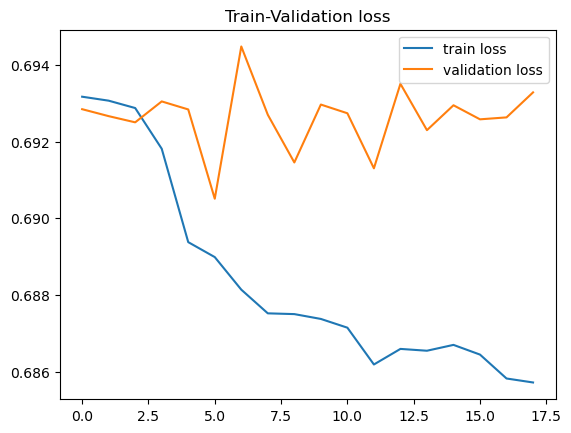

In [23]:
learning_rate = 5e-5
optimizer = AdamW(model.parameters(), lr=learning_rate)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path)

In [ ]:
del model
torch.cuda.empty_cache() 

In [30]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [12]:
model = rrnn.SingleTaskRRNN2(emb_dim,vocab_size,lstm_hidden_dim,emb_weights=word2vec_model.vectors).to(device)
save_path='m1_rrnn_simple_as_adam_w2v'
model.load_state_dict(torch.load(save_path))

for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.6632653061224489 

Using scikit learn accuracy por género en el conjunto about
MALE 0.4947916666666667
FEMALE 0.825 

GLOBAL: 0.5277777777777778 

Using scikit learn accuracy por género en el conjunto to
MALE 0.3722627737226277
FEMALE 0.6955380577427821 

GLOBAL: 0.5932203389830508 

Using scikit learn accuracy por género en el conjunto as
MALE 0.3888888888888889
FEMALE 0.8113207547169812 

